# Bayesian Binomial Regression 

This notebook is an introductory tutorial to Bayesian binomial regression with `RxInfer`.

In [9]:
# Activate local environment, see `Project.toml`
import Pkg; Pkg.activate(".."); Pkg.instantiate(); 

  Activating project at `~/.julia/dev/RxInfer/examples`


In [10]:
using RxInfer, ReactiveMP,Random, Plots, StableRNGs, LinearAlgebra, StatsPlots, LaTeXStrings

# Likelihood Specification
For observations $y_i$ with predictors $\mathbf{x}_i$, Binomial regression models the number of successes $y_i$ as a function of the predictors $\mathbf{x}_i$ and the regression coefficients $\boldsymbol{\beta}$

$$\begin{equation}
y_i \sim \text{Binomial}(n_i, p_i)\,,
\end{equation}$$
where:
$y_i$ is the number of successes, $n_i$ is the number of trials, $p_i$ is the probability of success. The probability $p_i$ is linked to the predictors through the logistic function:
$$\begin{equation}
p_i = \frac{1}{1 + e^{-\mathbf{x}_i^T\boldsymbol{\beta}}}
\end{equation}$$



# Prior Distributions
We specify priors for the regression coefficients:

$$\begin{equation}
\boldsymbol{\beta} \sim \mathcal{N}_{\xi}(\boldsymbol{\xi}, \boldsymbol{\Lambda})
\end{equation}$$
as a Normal distribution in precision-weighted mean form.



# Model Specification

The likelihood and the prior distributions form the probabilistic model
$$p(y, x, \beta, n) = p(\beta) \prod_{i=1}^N p(y_i \mid x_i, \beta, n_i),$$
where the goal is to infer the posterior distributions $p(\beta \mid y, x, n)$. Due to logistic link function, the posterior distribution is not conjugate to the prior distribution. This means that we need to use a more complex inference algorithm to infer the posterior distribution. Before dwelling into the details of the inference algorithm, let's first generate some synthetic data to work with.

In [61]:
function generate_synthetic_binomial_data(
    n_samples::Int,
    true_beta::Vector{Float64};
    seed::Int=42
)
    n_features = length(true_beta)
    rng = StableRNG(seed)
    
    X = randn(rng, n_samples, n_features)
    
    n_trials = rand(rng, 5:20, n_samples)
    
    logits = X * true_beta
    probs = 1 ./ (1 .+ exp.(-logits))
    
    y = [rand(rng, Binomial(n_trials[i], probs[i])) for i in 1:n_samples]
    
    return X, y, n_trials
end


n_samples = 10000
true_beta =  [-3.0 , 2.6]

X, y, n_trials = generate_synthetic_binomial_data(n_samples, true_beta);
X = [collect(row) for row in eachrow(X)];

We generate `X` as the design matrix and `y` as the number of successes and `n_trials` as the number of trials. Next task is to define the graphical model. RxInfer provides a `BinomialPolya` factor node that is a combination of a Binomial distribution and a PolyaGamma distribution introduced in [1]. The `BinomialPolya` factor node is used to model the likelihood of the binomial distribution. 

Due to non-conjugacy of the likelihood and the prior distribution, we need to use a more complex inference algorithm. RxInfer provides an Expectation Propagation (EP) [2] algorithm to infer the posterior distribution. Due to EP's approximation, we need to specify an inbound message for the regression coefficients while using the `BinomialPolya` factor node. 

In [62]:
@model function binomial_model(prior_xi, prior_precision, n_trials, X, y) 
    β ~ MvNormalWeightedMeanPrecision(prior_xi, prior_precision)
    for i in eachindex(y)
        y[i] ~ BinomialPolya(X[i], n_trials[i], β) where {
            dependencies = RequireMessageFunctionalDependencies(β = MvNormalWeightedMeanPrecision(prior_xi, prior_precision))
        }
    end
end

Havin specified the model, we can now utilize the `infer` function to infer the posterior distribution.

In [80]:
n_features = length(true_beta)
n_max_iterations = 50
strategy = StopEarlyIterationStrategy(1e-5, [])
results = infer(
    model = binomial_model(prior_xi = zeros(n_features), prior_precision = diageye(n_features),),
    data = (X=X, y=y,n_trials=n_trials),
    iterations = n_max_iterations,
    free_energy = true,
    options = (limit_stack_depth = 100,),
    showprogress = true,
    
)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02


Inference results:
  Posteriors       | available for (β)
  Free Energy:     | Real[21992.9, 16235.8, 13785.0, 12519.7, 11800.1, 11366.2, 11094.1, 10918.7, 10803.3, 10726.3  …  10558.2, 10558.2, 10558.2, 10558.1, 10558.1, 10558.1, 10558.1, 10558.1, 10558.1, 10558.1]


We can now plot the free energy to see if the inference algorithm is converging.

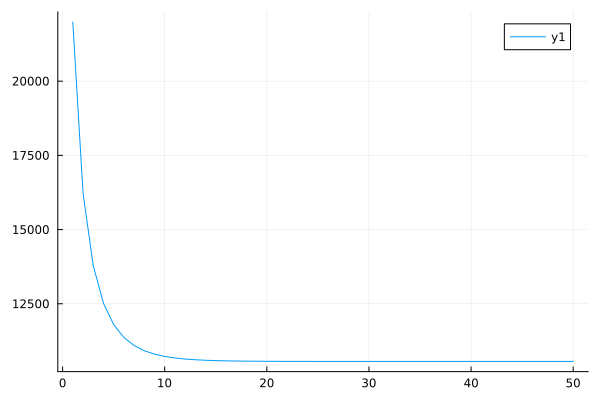

In [81]:
plot(results.free_energy[1:end])

Free energy is converging to a stable value, indicating that the inference algorithm is converging. Let's visualize the posterior distribution and how it compares to the true parameters.

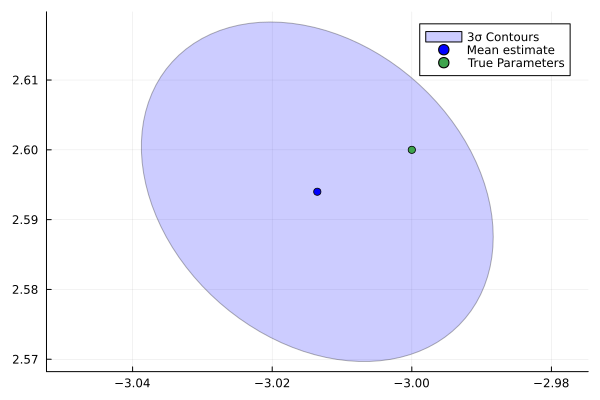

In [83]:
m = mean(convert(MvNormalMeanCovariance, results.posteriors[:β][end]))
Σ = cov(convert(MvNormalMeanCovariance, results.posteriors[:β][end]))

p = plot()
# i = 2
covellipse(m, Σ, aspect_ratio=1,n_std=3, label="3σ Contours", color=:blue, fillalpha=0.2)
scatter!([m[1]], [m[2]], label="Mean estimate", color=:blue)
scatter!([true_beta[1]], [true_beta[2]], label="True Parameters")

# References
[1] Polson, N. G., Scott, J. G., & Windle, J. (2013). Bayesian inference for logistic models using Polya-Gamma latent variables. *Journal of the American Statistical Association*, 108(1), 136-146.

[2] Minka, T. (2001). Expectation Propagation for approximate Bayesian inference. *Uncertainty in Artificial Intelligence*, 2, 362-369.